# Intro

<img src="images/iiit5k.png" width="600">
<p>This notebook demonstrates training and testing a CRNN model on the <a href="https://cvit.iiit.ac.in/projects/SceneTextUnderstanding/IIIT5K.html">IIIT 5K-word dataset</a>. As the picture above shows, this dataset contains images with some text and the true text for each of these images.</p>

# Import dependencies

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pathlib import Path
from mat4py import loadmat
from PIL import Image
import os

import sys
sys.path.insert(0, "..")
import crnn

%matplotlib inline

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Download and preprocess the dataset

First, let's download and extract the dataset:<br/>
(**Warning: 106 MB download!**)

In [2]:
dataset_path = tf.keras.utils.get_file(
    "IIIT5K-Word_V3.0.tar.gz",
    "http://cvit.iiit.ac.in/projects/SceneTextUnderstanding/IIIT5K-Word_V3.0.tar.gz",
    extract=True)
dataset_path = Path(dataset_path).parent / "IIIT5K"
dataset_path

PosixPath('/home/oleg/.keras/datasets/IIIT5K')

The dataset provides true text for each image in a form of dictionaries, so that image's filename can be used as a key to retreive the true text for this image:

In [3]:
def load_filename_to_text_dict(dataset_path, name):
    filename_to_text = loadmat((dataset_path / f"{name}.mat").as_posix())[name]
    return {Path(path).name: text
            for path, text in zip(filename_to_text["ImgName"],
                                  filename_to_text["GroundTruth"])}

filename_to_text_train = load_filename_to_text_dict(dataset_path, "traindata")
filename_to_text_test = load_filename_to_text_dict(dataset_path, "testdata")

Since we have true text for all images, we can select unique characters:

In [4]:
unique_chars = np.asarray(
    sorted({c for text in filename_to_text_train.values() for c in text}))
unique_chars

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], dtype='<U1')

To make the true text dictionaries usable from TensorFlow graphs, we need to convert them to `StaticHashTable`'s:

In [5]:
def dict_to_tf(dictionary, default_value=""):
    keys = list(dictionary.keys())
    values = [dictionary[key] for key in keys]
    return tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys, values), default_value)

filename_to_text_train = dict_to_tf(filename_to_text_train)
filename_to_text_test = dict_to_tf(filename_to_text_test)

Let's plot some images from the train dataset with their texts from the dictionary to check that everything works as expected:

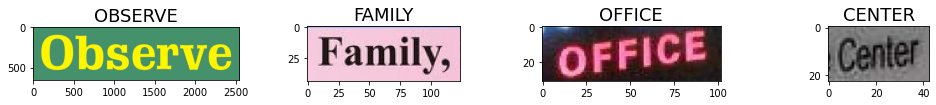

In [6]:
def plot_images(images, text, rows, columns, cmap=None, norm=None):
    for i in range(len(images)):
        image = images[i]
        plt.subplot(rows, columns, i + 1)
        plt.title(text[i], {'fontsize': 18})
        plt.imshow(image, cmap=cmap, norm=norm)

image_paths = list((dataset_path / "train").glob("*.png"))[:4]
images = [np.asarray(Image.open(path)) for path in image_paths]
text = [filename_to_text_train.lookup(tf.constant(path.name)).numpy().decode("UTF-8")
        for path in image_paths]

plt.figure(figsize=(17, 1))
plot_images(images, text, 1, 4)

And knowing the unique characters we can create `StaticHashTable`'s to encode characters with numeric labels and to decode them back:

In [7]:
labels = np.arange(unique_chars.size, dtype=np.int32)
char_to_label = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(unique_chars, labels), -1)
label_to_char = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(labels, unique_chars), "")

We also will need a function to split a tensor into separate characters before encoding them:

In [8]:
def split_chars(tensor, encoding="UTF-8"):
    return tf.strings.unicode_split(tensor, encoding)

Let's encode and decode back an example word:

In [9]:
source_word = split_chars("TENSORFLOW", "UTF-8")
print("A source word:  ", source_word.numpy())

encoded_word = char_to_label.lookup(source_word)
print("An encoded word:", encoded_word.numpy())

decoded_word = label_to_char.lookup(encoded_word)
print("A decoded word: ", decoded_word.numpy())

A source word:   [b'T' b'E' b'N' b'S' b'O' b'R' b'F' b'L' b'O' b'W']
An encoded word: [29 14 23 28 24 27 15 21 24 32]
A decoded word:  [b'T' b'E' b'N' b'S' b'O' b'R' b'F' b'L' b'O' b'W']


Now we can build train and test datasets using the `tf.data` API. This is a pretty standard images loading routine, except that all images are scaled to have the same height:

In [10]:
IMAGE_CHANNELS = 1 # Images will be converted to grayscale
IMAGE_HEIGHT = 32

rescaling = tf.keras.layers.experimental.preprocessing.Rescaling(
    scale=1./127.5, offset=-1)

def build_dataset(path, filename_to_text, char_to_label):
    files_ds = tf.data.Dataset.list_files((path / "*.png").as_posix(), shuffle=False)
    return files_ds.map(
        lambda image_path: (load_image(image_path),
                            get_labels(image_path, filename_to_text, char_to_label)),
        num_parallel_calls=AUTOTUNE)

def load_image(path):
    image_data = tf.io.read_file(path)
    image = tf.image.decode_png(image_data, channels=IMAGE_CHANNELS)
    image = rescaling(image)
    
    # All the images are scaled to the same height
    source_shape = tf.shape(image)
    scale_factor = IMAGE_HEIGHT / tf.cast(source_shape[0], tf.float32)
    new_width = tf.cast(source_shape[1], tf.float32) * scale_factor
    image = tf.image.resize(image, [IMAGE_HEIGHT, new_width])
    
    return image

def get_labels(path, filename_to_text, char_to_label):
    image_name = tf.strings.split(path, os.path.sep)[-1]
    image_text = filename_to_text.lookup(image_name)
    labels = char_to_label.lookup(split_chars(image_text))
    return labels

In [11]:
train_ds = build_dataset(
    dataset_path / "train", filename_to_text_train, char_to_label)
test_ds = build_dataset(
    dataset_path / "test", filename_to_text_test, char_to_label)

Finally, we need to batch our datasets and configure them for performance. This is again a common procedure. The only special thing here is that all images have different width (height is the same since we scaled them before) and their true text consists of different number of characters. To be able to batch tensors of different shape together, we need to use the `padded_batch()` function. The CTC loss, that we will use for the model, is able to handle padded labels, and padded images also shouldn't become a problem since the model can just learn to predict the "blank" character for all empty regions that were added to an image after padding.

In [12]:
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 32
IMAGE_PADDING_CONST = 0.0
LABELS_PADDING_CONST = -1

def configure_for_performance(dataset, shuffle=False, seed=None):
    dataset = dataset.cache()
    if shuffle:
      dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE, seed=seed)
    dataset = dataset.padded_batch(
        BATCH_SIZE, padding_values=(IMAGE_PADDING_CONST, LABELS_PADDING_CONST))
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

train_ds = configure_for_performance(train_ds, shuffle=True, seed=42)
test_ds = configure_for_performance(test_ds) 

Let's plot some images with their true text from our final training dataset to make sure that everything is alright:

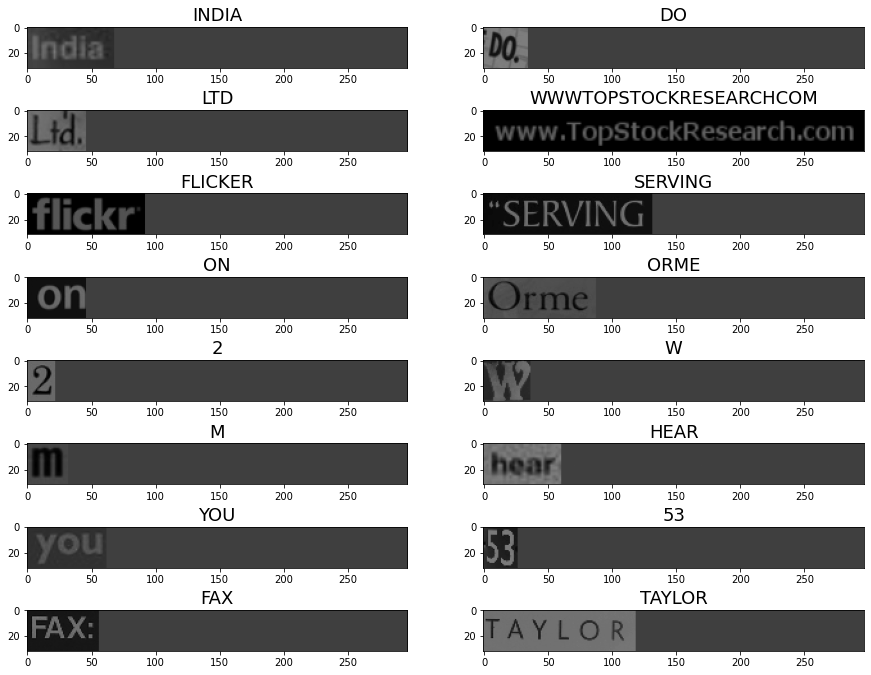

In [13]:
images, labels = next(iter(train_ds))
images, labels = images[:16], labels[:16]
images = [(np.squeeze(image) + 1) / 2 for image in images.numpy()]
text = ["".join(c.decode("UTF-8") for c in chars)
        for chars in label_to_char.lookup(labels).numpy()]
    
plt.figure(figsize=(15, 12))
plot_images(images, text, rows=len(images) / 2, columns=2, 
            cmap="binary", norm=matplotlib.colors.Normalize(-1, 1))